In [10]:
""" COMMON CODE BLOCK FOR PARSING GENBANK FILES 
RETURNS DATA STRUCTURES FOR USE IN SEBSEQUENT CODE BLOCK 

Notes: 'goodgenes' contains the coding sequences, and 'goodnames' contains annotation info
"""
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats
from google.colab import drive
import seaborn as sns  

# insert the sequence file path and name into 'userFile'
userFile = '/content/gdrive/Shared drives/2.Python/Genomics/Data Files/E.coli.K12.sequence.2.gb'  

drive.mount('/content/gdrive')
with open(userFile, 'r') as f:
  data = f.read()
f.close()
txtfile = str(data)
start = 3
stop  = 3
frame = 0

#Breaks out the features and the sequence
split1 = txtfile.split('FEATURES') #list[0] is annotations, [1] is the good stuff
split2 = split1[1].split('ORIGIN')  #divides gene locations [0] and genome sequence [1]
features = split2[0].split('  gene  ')  #separates each gene location and puts them in a list
seq = ''
for char in split2[1]:                  #puts sequence in a single, long string
    if char in ('t', 'g', 'c', 'a'):
        seq += char
        
print('The number of "Features" lines =', len(features))
print('The first Features line starts with:', features[1][:100])
print('The first 100 nucleotides =', seq[:100])        
split1[0] = '' #deletes from memory the annotations in the beginning of the gb file  
split2[0] = '' #deletes from memory the unsplit features list  

#COLLECT ALL THE FORWARD AND REVERSE GENES and labels them as 'FOR' or 'REV'
names =[]
forward =0
reverse =0

for x in range(1, len(features)):
  if 'join' not in features[x]:
    if 'complement' not in features[x]:genedirection = 'FOR'
    elif 'complement' in features[x]:  genedirection = 'REV'
    cleanfeatures = features[x].replace('complement(','').replace(')', '')\
    .replace('/', '').replace(' ', '').replace('gene="', '').replace('"', '')
    workgene = cleanfeatures.split('\n')
    genename = workgene[1]
    genelocation = workgene[0].split('.')
    genestart = genelocation[0] 
    geneend = genelocation[2] 
    genedata = [genedirection, genename, genestart, geneend, 0, 0.0]
    names.append(genedata)
              
#converts gene starts and ends to integers.  Calulates gene length
print('The number of annotated genes =', len(names))
for y in range(len(names)):
  try:
    names[y][2] = int(names[y][2])
    names[y][3] = int(names[y][3])
    names[y][4] = int(names[y][3]) - int(names[y][2])
  except: print('Bad gene:', names[y])
                  
genes =[]
for x in range(len(names)):
  if names[x][0] == 'FOR':
    cds = seq[names[x][2] -1 : names[x][3]]
  elif names[x][0] == 'REV':
    transposed = ''
    flipped = seq[names[x][2] -1 : names[x][3]]
    for char in flipped:
      if char == 'a': newchar = 't'
      elif char == 't': newchar = 'a'
      elif char == 'c': newchar = 'g'
      elif char == 'g': newchar = 'c'
      transposed += newchar
    cds = transposed[::-1]
  genes.append(cds)

#collects only those sequences that have proper start codons
startgenes =[]
startnames =[]
for x in range(len(genes)):
  if genes[x][0:3]  in ('atg', 'gtg', 'ctg', 'ttg', 'att', 'ata', 'aaa'):
    startgenes.append(genes[x])
    startnames.append(names[x])

#Collects only those sequences that do not contain internal stop codons
goodgenes =[]
goodnames =[]
badgenes = set()
for x in range(len(startgenes)):
  keep = True
  for a in range(start, len(startgenes[x]) - stop):
    if a % 3 == 0 :
      if startgenes[x][a:a+3] in ('tag', 'taa', 'tga'): 
        badgenes.add(startnames[x][1])
        keep = False
        continue
  if keep == True:
    goodgenes.append(startgenes[x])
    goodnames.append(startnames[x])  

print('The number of good genes =', len(goodnames))
totalcodons = -2 * len(goodgenes)
frequency =[]
for x in range(len(goodgenes)):
    totalcodons += len(goodgenes[x]) / 3  
print( 'Total codons =', round(totalcodons ))
"""
start = 9
stop = start + 90
"""

#  Kyte & Doolittle hydropathy index, size in Angstroms
idlist = [
    ["A", 1.8, 0.77, ['gct', 'gcc' , 'gca', 'gcg']],
    ["C", 2.5, 1.38, ['tgt', 'tgc']],
    ["D", -3.5, 1.99, ['gat', 'gac']], 
    ["E", -3.5, 2.63, ['gaa', 'gag']],
    ["F", 2.8, 2.97, ['ttt', 'ttc']],
    ["G", -0.4, 0.0, ['ggt', 'ggc', 'gga', 'ggg']],
    ["H", -3.2, 2.76,  ['cat', 'cac']], 
    ["I", 4.5, 1.83, ['att', 'atc', 'ata']],
    ["K", -3.9, 2.94,  ['aaa', 'aag']], 
    ["L", 3.8, 2.08, ['tta', 'ttg', 'ctt', 'ctc', 'cta', 'ctg']],
    ["M", 1.9, 2.34, ['atg']],
    ["N", -3.5, 1.98, ['aat', 'aac']],
    ["P", -1.6, 1.42,  ['cct', 'ccc', 'cca', 'ccg']],
    ["Q", -3.5, 2.58, ['caa', 'cag']],
    ["R", -4.5, 3.72, ['cgt', 'cgc', 'cga', 'cgg', 'aga', 'agg']],
    ["S", -0.8, 1.28, ['tct', 'tcc', 'tca', 'tcg', 'agt', 'agc']],
    ["T", -0.7, 1.43, ['act', 'acc', 'aca', 'acg']],
    ["V", 4.2, 1.49, ['gtt', 'gtc', 'gta', 'gtg']],
    ["W", -0.9, 3.58,  ['tgg']],
    ["Y", -1.3, 3.36,  ['tau', 'tac']]
   ]
idlist.sort(key=lambda x: x[1])

zeros =[]
for x in range(round((stop - start) /3 )):
  zeros.append(0)

aas =[]
for x in range(len(idlist)):
  idlist[x].append(zeros.copy())
  aas.append(idlist[x][0])

# Fill out array for aa usage at each position in the 15 codon window
for a in range(len(goodgenes)):
  for b in range(start, stop):
    if b % 3 == 0:
      position = round((b - start) /3 )
      codon = goodgenes[a][b:b+3].lower()
      for c in range(len(idlist)):
        if codon in idlist[c][3]:
          idlist[c][4][position] +=1

codons = ['ttt','ttc','tta','ttg', 'ctt','ctc','cta','ctg', 'att','atc','ata','atg', 'gtt','gtc','gta','gtg',\
          'tct','tcc','tca','tcg', 'cct','ccc','cca','ccg', 'act','acc','aca','acg', 'gct','gcc','gca','gcg',\
          'tat','tac','taa','tag', 'cat','cac','caa','cag', 'aat','aac','aaa','aag', 'gat','gac','gaa','gag',\
          'tgt','tgc','tga','tgg', 'cgt','cgc','cga','cgg', 'agt','agc','aga','agg', 'ggt','ggc','gga','ggg']


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The number of "Features" lines = 4567
The first Features line starts with:           190..255
                     /gene="thrL"
                     /locus_tag="b0001"
       
The first 100 nucleotides = agcttttcattctgactgcaacgggcaatatgtctctgtgtggattaaaaaaagagtgtctgatagcagcttctgaactggttacctgccgtgagtaaat
The number of annotated genes = 4546
The number of good genes = 4119
Total codons = 1258400


sums 4119 1246045


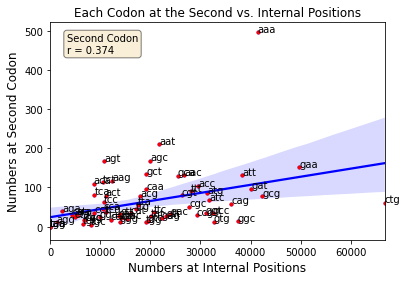

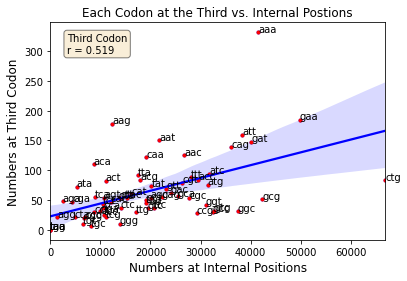

In [2]:
""" FIGURE 2. CODON frequencies between the second and third codons and internal positions
"""
target = 'atg'

inel = []                            # fill array with lists of codons and 0 counts for init and elong
for x in range(len(codons)):
  inel.append([codons[x], 0, 0, 0])

# THIS SECTION LOOKS AT ALL SECOND CODONS vs ALL INTERNAL CODONS
for x in range(len(goodgenes)):      # count codons at 2nd position
  for b in range(len(inel)):
    if inel[b][0] == goodgenes[x][3:6] : inel[b][1] +=1
    if inel[b][0] == goodgenes[x][6:9] : inel[b][2] +=1

for x in range(len(goodgenes)):
  for a in range(9, len(goodgenes[x]) -6):
    if a % 3 == 0:
      for b in range(len(inel)):
          if inel[b][0] == goodgenes[x][a:a+3] : inel[b][3] +=1
           
sumstart =0
sumelong =0
for x in range(len(inel)):
  sumstart += inel[x][1]
  sumelong += inel[x][3]
print('sums', sumstart, sumelong)

for x  in range(len(inel)):             
  if inel[x][3] >0:
    startfrq = inel[x][1] / sumstart
    thirdfrq = inel[x][2] / sumstart
    elongfrq = inel[x][3] / sumelong
    inel[x].append( startfrq / elongfrq )      # inel[4]
  else: 
    inel[x].append(0)
inel.sort(key = lambda x: x[1])

xval, yval2, yval3, cod, barval = [], [], [], [], []
for x in range(len(inel)):
  xval.append(inel[x][3])
  yval2.append(inel[x][1])
  yval3.append(inel[x][2])
  barval.append(inel[x][1])
  cod.append(inel[x][0])

elongmax = max(xval)
slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(xval, yval2)
slope3, intercept3, r_value3, p_value3, std_err = stats.linregress(xval, yval3)

scatter, ax = plt.subplots()
plots = sns.regplot(x= xval, y= yval2, marker = '.', color='b')
textstr = 'Second Codon\nr = ' +str(r_value2)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
for i,type in enumerate(cod):
    xa =  xval[i]
    ya =  yval2[i]
    plt.scatter(xa, ya, marker='.', color='r')
    plt.text(xa+ 2, ya+ 0.5, cod[i], fontsize=10)
plt.title('Each Codon at the Second vs. Internal Positions', fontsize =12)
plt.xlabel('Numbers at Internal Positions', fontsize =12)
plt.ylabel('Numbers at Second Codon', fontsize =12)
plt.show()

scatter, ax = plt.subplots()
plots = sns.regplot(x= xval, y= yval3, marker = '.', color='b')
textstr = 'Third Codon\nr = ' +str(r_value3)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
for i,type in enumerate(cod):
    xa =  xval[i]
    ya =  yval3[i]
    plt.scatter(xa, ya, marker='.', color='r')
    plt.text(xa+ 2, ya+ 0.5, cod[i], fontsize=10)
plt.title('Each Codon at the Third vs. Internal Postions', fontsize =12)
plt.xlabel('Numbers at Internal Positions', fontsize =12)
plt.ylabel('Numbers at Third Codon', fontsize =12)
plt.show()

codonlist = [['ttt', 0, 0, 0, 0, 0, 0, 0, 0], ['ttc', 0, 0, 0, 0, 0, 0, 0, 0], ['tta', 0, 0, 0, 0, 0, 0, 0, 0], ['ttg', 0, 0, 0, 0, 0, 0, 0, 0], ['ctt', 0, 0, 0, 0, 0, 0, 0, 0], ['ctc', 0, 0, 0, 0, 0, 0, 0, 0], ['cta', 0, 0, 0, 0, 0, 0, 0, 0], ['ctg', 0, 0, 0, 0, 0, 0, 0, 0], ['att', 0, 0, 0, 0, 0, 0, 0, 0], ['atc', 0, 0, 0, 0, 0, 0, 0, 0], ['ata', 0, 0, 0, 0, 0, 0, 0, 0], ['atg', 0, 0, 0, 0, 0, 0, 0, 0], ['gtt', 0, 0, 0, 0, 0, 0, 0, 0], ['gtc', 0, 0, 0, 0, 0, 0, 0, 0], ['gta', 0, 0, 0, 0, 0, 0, 0, 0], ['gtg', 0, 0, 0, 0, 0, 0, 0, 0], ['tct', 0, 0, 0, 0, 0, 0, 0, 0], ['tcc', 0, 0, 0, 0, 0, 0, 0, 0], ['tca', 0, 0, 0, 0, 0, 0, 0, 0], ['tcg', 0, 0, 0, 0, 0, 0, 0, 0], ['cct', 0, 0, 0, 0, 0, 0, 0, 0], ['ccc', 0, 0, 0, 0, 0, 0, 0, 0], ['cca', 0, 0, 0, 0, 0, 0, 0, 0], ['ccg', 0, 0, 0, 0, 0, 0, 0, 0], ['act', 0, 0, 0, 0, 0, 0, 0, 0], ['acc', 0, 0, 0, 0, 0, 0, 0, 0], ['aca', 0, 0, 0, 0, 0, 0, 0, 0], ['acg', 0, 0, 0, 0, 0, 0, 0, 0], ['gct', 0, 0, 0, 0, 0, 0, 0, 0], ['gcc', 0, 0, 0, 0, 0, 0, 0, 0

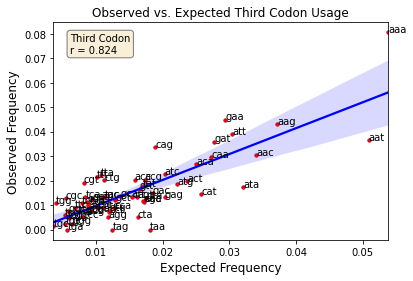

In [3]:
""" FIGURES 3&4
 calculate expected codon frequencies based on nucleotide frequesncies 
 and compare to observed codon frequecies
"""

codonlist = []
for x in range(len(codons)):
  codonlist.append([codons[x]])
  for y in range(8):
    codonlist[x].append(0)
print('codonlist =', codonlist)

nucprobs = [ ['a', 0,0,0,0,0,0], ['t', 0,0,0,0,0,0], ['c', 0,0,0,0,0,0], ['g', 0,0,0,0,0,0] ]

for a in range(len(goodgenes)):
  for b in range(3, 9):
    if   goodgenes[a][b] == 'a':  nucprobs[0][b-2] +=1 /len(goodgenes)
    elif goodgenes[a][b] == 't':  nucprobs[1][b-2] +=1 /len(goodgenes)
    elif goodgenes[a][b] == 'c':  nucprobs[2][b-2] +=1 /len(goodgenes)
    elif goodgenes[a][b] == 'g':  nucprobs[3][b-2] +=1 /len(goodgenes)
print('Nucprobs=', nucprobs)

for x in range(len(goodgenes)):
  codon2nd, codon3rd, plus1, plus2 = goodgenes[x][3:6], goodgenes[x][6:9], goodgenes[x][4:7], goodgenes[x][5:8]
  for y in range(len(codonlist)):
    if codon2nd == codonlist[y][0]:
      codonlist[y][1] +=1 / len(goodgenes)
    if codon3rd == codonlist[y][0]:
      codonlist[y][2] +=1 / len(goodgenes)
    if plus1 == codonlist[y][0]:
      codonlist[y][5] +=1 / len(goodgenes)
    if plus2 == codonlist[y][0]:
      codonlist[y][6] +=1 / len(goodgenes)

for a in range(4):
  for b in range(4):
    for c in range(4):
      codon = nucprobs[a][0] + nucprobs[b][0] + nucprobs[c][0]
      for x in range(len(codonlist)):
        if codon == codonlist[x][0]:
          codonlist[x][3] = nucprobs[a][1] * nucprobs[b][2] * nucprobs[c][3]
          codonlist[x][4] = nucprobs[a][4] * nucprobs[b][5] * nucprobs[c][6]
          codonlist[x][7] = nucprobs[a][2] * nucprobs[b][3] * nucprobs[c][4]
          codonlist[x][8] = nucprobs[a][3] * nucprobs[b][4] * nucprobs[c][5]

print('Codonlist=', codonlist)

labels, exp2nd, obs2nd, exp3rd, obs3rd, obspls1, obspls2, exppls1, exppls2 = [], [], [], [], [], [], [], [], []
for x in range(len(codonlist)):
  labels.append(codonlist[x][0])
  obs2nd.append(codonlist[x][1])
  obs3rd.append(codonlist[x][2])
  exp2nd.append(codonlist[x][3])
  exp3rd.append(codonlist[x][4])
  obspls1.append(codonlist[x][5])
  obspls2.append(codonlist[x][6])
  exppls1.append(codonlist[x][7])
  exppls2.append(codonlist[x][8])

####  GENERIC SEABORN PLOT. 
#Place the desired pair of variables into XX and YY. Change plot figure labels

#obs2nd, obs3rd, exp2nd, exp3rd, obspls1, obspls2, exppls1, exppls2 

XX = exp3rd.copy()
YY = obs3rd.copy()
slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(XX, YY)
fig, ax = plt.subplots()
plots = sns.regplot(x= XX, y= YY, marker = '.', color='b')
textstr = 'Third Codon\nr = ' +str(r_value2)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
for i,type in enumerate(labels):
    xa =  XX[i]
    ya =  YY[i]
    plt.scatter(xa, ya, marker='.', color='r')
    plt.text(xa, ya, labels[i], fontsize=10)
plt.title('Observed vs. Expected Third Codon Usage', fontsize =12)
plt.xlabel('Expected Frequency', fontsize =12)
plt.ylabel('Observed Frequency', fontsize =12)
plt.show()


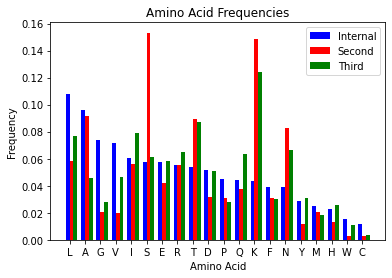

In [4]:
""" FIGURE 5. # AMINO ACID context at ATG in both initiation and internal positions.  
# CODON contexts are in the last block
"""
# YOU MUST """ OUT EITHER THE 'ALL CODONS' OR 'ONLY THOSE AFTER ATG' SECTIONS

target = 'atg'
inel = []                            # fill array with lists of codons and 0 counts for init and elong
for x in range(len(codons)):
  inel.append([codons[x], 0, 0, 0])

# THIS SECTION LOOKS AT ALL SECOND CODONS vs ALL INTERNAL CODONS
for x in range(len(goodgenes)):      # count codons at 2nd position
  for a in range(len(inel)):
    if goodgenes[x][3:6] == inel[a][0]: inel[a][1] +=1
    if goodgenes[x][6:9] == inel[a][0]: inel[a][2] +=1

for x in range(len(goodgenes)):
  for a in range(9, len(goodgenes[x]) -6):
    if a %3 == 0:
      for b in range(len(inel)):
        if inel[b][0] == goodgenes[x][a:a+3] : inel[b][3] +=1

aas =  [ [('ttt', 'ttc'), 'F', 0, 0, 0], [('tta','ttg', 'ctt', 'ctc', 'cta', 'ctg'), 'L', 0, 0, 0] , 
      [('att', 'atc', 'ata'), 'I', 0,0, 0], [('atg'), 'M', 0, 0, 0], [('gtt', 'gtc', 'gta', 'gtg'), 'V', 0, 0, 0],
      [('tct', 'tcc', 'tca', 'tcg', 'agt', 'agc'), 'S', 0, 0, 0], [('cct', 'ccc', 'cca', 'ccg'), 'P', 0, 0, 0],\
      [('act', 'acc', 'aca', 'acg'), 'T', 0, 0, 0], [('gct', 'gcc', 'gca', 'gcg'), 'A', 0, 0, 0],\
      [('tat', 'tac'), 'Y', 0, 0, 0], [('cat', 'cac'), 'H', 0, 0, 0], [('caa', 'cag'), 'Q', 0, 0, 0],\
      [('aat', 'aac'), 'N', 0, 0, 0], [('gat', 'gac'), 'D', 0, 0, 0], [('gaa', 'gag'), 'E', 0, 0, 0],\
      [('tgt', 'tgc'), 'C', 0, 0, 0], [('tgg'), 'W', 0, 0, 0],\
      [('cgt', 'cgc', 'cga', 'cgg', 'aga', 'agg'),'R', 0, 0, 0], [('ggt', 'ggc', 'gga', 'ggg'), 'G', 0, 0, 0],\
      [('aaa', 'aag'), 'K', 0, 0, 0]  ]

for x in range(len(inel)):
  for y in range(len(aas)):
    if inel[x][0] in aas[y][0] : 
      aas[y][2] += inel[x][1]
      aas[y][3] += inel[x][2]
      aas[y][4] += inel[x][3]

sumfirst =0
sumsecond =0
sumelong =0
for x in range(len(aas)):
  sumfirst += aas[x][2]
  sumsecond += aas[x][3]
  sumelong += aas[x][4]

for x  in range(len(aas)):
  firstfrq = aas[x][2] / sumfirst
  secondfrq = aas[x][3] /sumsecond
  elongfrq = aas[x][4] / sumelong
  aas[x].append( firstfrq )
  aas[x].append( secondfrq )
  aas[x].append( elongfrq )
# aas = set, name, fst, snd, eln, frqfst, frqsnd, frqeln
#       0     1     2    3    4     5        6      7
aas.sort(key = lambda x: x[4])
aas.reverse()
#for z in range(len(aas)):
 # print (str(z+1) + 'th', aas[z])

barnames, barvals1, barvals2, barvals3 = [], [], [], []
for x in range(len(aas)):
  barnames.append(aas[x][1])
  barvals1.append(aas[x][7])
  barvals2.append(aas[x][5])
  barvals3.append(aas[x][6])

# create plot
fig, ax = plt.subplots()
index = np.arange(len(aas))
bar_width = 0.25
opacity = 1

plt.bar(index, barvals1, bar_width,
alpha=opacity,
color='b',
label='Internal')

plt.bar(index + bar_width, barvals2, bar_width,
alpha=opacity,
color='r',
label='Second')

plt.bar(index + 2* bar_width, barvals3, bar_width,
alpha=opacity,
color='g',
label='Third')

plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Amino Acid Frequencies')
plt.xticks(index + bar_width /2, barnames) #, rotation = 90)
plt.legend()
plt.show()

[['ttt', 91, 28053], ['ttc', 37, 20761], ['tta', 56, 17507], ['ttg', 45, 17062], ['ctt', 32, 13958], ['ctc', 21, 14096], ['cta', 24, 4890], ['ctg', 61, 66801], ['att', 132, 38317], ['atc', 67, 31746], ['ata', 31, 5298], ['atg', 86, 31389], ['gtt', 27, 23177], ['gtc', 15, 19443], ['gta', 26, 13719], ['gtg', 13, 32690], ['tct', 114, 10527], ['tcc', 63, 10765], ['tca', 82, 8839], ['tcg', 37, 11123], ['cct', 36, 8837], ['ccc', 16, 6973], ['cca', 45, 10575], ['ccg', 30, 29251], ['act', 79, 11074], ['acc', 103, 29501], ['aca', 110, 8680], ['acg', 77, 17998], ['gct', 134, 19188], ['gcc', 35, 32445], ['gca', 130, 25432], ['gcg', 78, 42298], ['tat', 27, 20185], ['tac', 20, 15301], ['taa', 0, 0], ['tag', 0, 0], ['cat', 35, 16138], ['cac', 18, 12107], ['caa', 96, 19202], ['cag', 59, 36151], ['aat', 210, 21797], ['aac', 132, 26763], ['aaa', 496, 41455], ['aag', 117, 12427], ['gat', 97, 40148], ['gac', 32, 24021], ['gaa', 152, 49745], ['gag', 21, 22252], ['tgt', 8, 6519], ['tgc', 5, 8129], ['tga', 

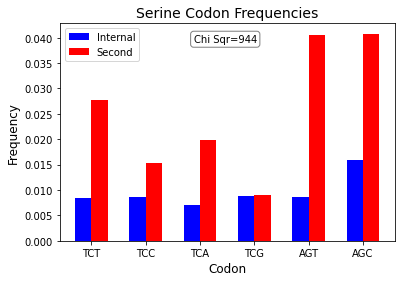

In [5]:
""" FIGURE 6.  CODON frequencies between the SECOND CODON ONLY and internal 
positions FOR SPECIFIC AMINO ACIDS  
"""
# YOU MUST """ OUT EITHER THE SECTION FOR ALL CODONS OR FOR ONLY THOSE FOLLOWING ATG

target = 'atg'
Isoleucine, Serine = ['gtt', 'gtg', 'gtc', 'gta'], ['tct', 'tcc', 'tca', 'tcg', 'agt', 'agc']  
Lysine, Leucine = ['aaa', 'aag'], ['tta', 'ttg', 'ctt', 'ctc', 'cta', 'ctg']
Glutamine, Phenylalanine, Glycine = ['caa', 'cag'], [ 'ttt', 'ttc'], ['ggt', 'ggc', 'gga', 'ggg']
Arginine, Valine, Alanine =  ['cgt', 'cgc', 'cga', 'cgg', 'aga', 'agg'], ['gtt', 'gtc', 'gta', 'gtg'], ['gct', 'gcc', 'gca', 'gcg']
Cysteine, Tyrosine, Histidine, Threonine, Glutamic_Acid  = ['tgt', 'tgc'], ['tat', 'tac'], ['cat', 'cac'], ['act', 'acc', 'aca', 'acg'], ['gaa', 'gag']
Proline, Methionine, Tryptophan, Asparagine, Aspartic_Acid = ['cct', 'ccc', 'cca', 'ccg'], ['atg'], ['tgg'], ['aat', 'aac'], ['gat', 'gac']

aalist = Serine
aaname = 'Serine'

inel = []                            # fill array with lists of codons and 0 counts for init and elong
for x in range(len(codons)):
  inel.append([codons[x], 0, 0])

# THIS SECTION LOOKS AT ALL SECOND CODONS vs ALL INTERNAL CODONS
for x in range(len(goodgenes)):      # count codons at 2nd position
  for b in range(len(inel)):
    if inel[b][0] == goodgenes[x][3:6] : inel[b][1] +=1

for x in range(len(goodgenes)):
  for a in range(9, len(goodgenes[x]) -6):
    if a % 3 == 0:
      for b in range(len(inel)):
          if inel[b][0] == goodgenes[x][a:a+3] : inel[b][2] +=1
print(inel)

sum2nd, sumelong =0, 0 
for x in range(len(inel)):
  sum2nd += inel[x][1]
  sumelong += inel[x][2]
print('Sums=', sum2nd, sumelong)

for x  in range(len(inel)):             
  if inel[x][0] in aalist and inel[x][2] >0:
    sndfrq = inel[x][1] / sum2nd
    elongfrq = inel[x][2] / sumelong
    inel[x].append( sndfrq / elongfrq )    
  else: 
    inel[x].append(0)
    inel[x].append(0)

print('inel=', inel)
# Amino acids
pltaalist = []
for x in range(len(inel)):
  if inel[x][0] in aalist:
    pltaalist.append( [ inel[x][0], inel[x][1], inel[x][2] ])#, inel[x][3] ])

sumstart = 4119
sumelong = totalcodons - 2*len(goodnames)
for x in range(len(pltaalist)):
  pltaalist[x].append(pltaalist[x][1] / sum2nd)
  pltaalist[x].append(pltaalist[x][2] / sumelong)

# calculate Chi square
sumsnd,  sumint =0, 0
for x in range(len(pltaalist)):
  sumsnd += pltaalist[x][3]
  sumint += pltaalist[x][4]

scaled =  sumint / sumsnd
chisum2nd = 0.0
for x in range(len(pltaalist)):
  chisum2nd += (pltaalist[x][1]  - len(goodgenes) * pltaalist[x][4])**2  / (len(goodgenes) * pltaalist[x][4] )
print('Chi^2 vales:', chisum2nd)

#plotting
barnames, barvals1, barvals2 = [], [], []
for x in range(len(pltaalist)):
  barnames.append(pltaalist[x][0].upper())
  barvals1.append(pltaalist[x][4])
  barvals2.append(pltaalist[x][3])

# create plot
fig, ax = plt.subplots()
index = np.arange(len(barnames))
bar_width = 0.3
opacity = 1
print(index)

plt.bar(index, barvals1, bar_width,
alpha=opacity,
color='b', 
label='Internal')

plt.bar(index + bar_width, barvals2, bar_width,
alpha=opacity,
color='r',
label='Second')

textstr = 'Chi Sqr=' + str(chisum2nd)[:3] #+'\nChi 3rd= ' + str(chisum3rd)[:6] 
props = dict(boxstyle='round', facecolor='white',alpha=0.5)  # 
ax.text(0.4, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', horizontalalignment= 'left', bbox=props)

plt.xlabel('Codon', fontsize =12)
plt.ylabel('Frequency',  fontsize =12)
plt.title(aaname+ ' Codon Frequencies',  fontsize =14)
plt.xticks(index + 0.5*bar_width, barnames, fontsize =10)  
#plt.xticks(index + bar_width, barnames, fontsize =10) #rotation = 90, 
plt.legend()
plt.show()

max2 = 444 max3 = 301
fraction of non-ATG genes = 0.10075260985676135


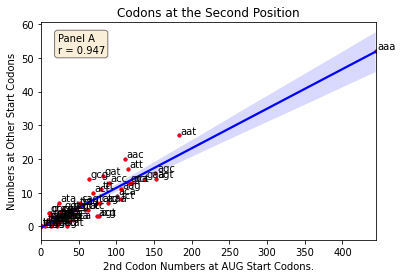

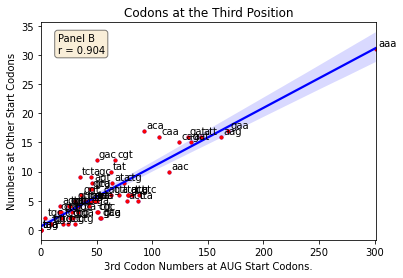

In [6]:
""" FIGURE 7.  # this block counts and plots neighbors for ATG-starters vs those at other start codons
# it addresses two codons, the second and the third
"""
start, stop = 3, 3

counts =[]
for x in range(len(codons)):
  counts.append(0)

for x in range(len(goodgenes)):
    for a in range(start, len(goodgenes[x]) -stop): 
        if a % 3 == frame  :
            codon = goodgenes[x][a:a+3] 
            for b in range(len(codons)):
                if codons[b] == codon: counts[b] += 1  

codcon = []
for x in range(len(codons)):
  codcon.append([codons[x], 0, 0, 0, 0])

atggenes =0
btggenes =0
for x in range(len(goodgenes)):
  start  = goodgenes[x][0:3]  
  second = goodgenes[x][3:6]  
  third  = goodgenes[x][6:9]  
  if start == 'atg':
    atggenes +=1
    for b in range(len(codcon)):
      if second == codcon[b][0] : codcon[b][1] += 1
      if third  == codcon[b][0] : codcon[b][2] += 1
  else:
    btggenes +=1
    for b in range(len(codons)):
      if second == codcon[b][0] : codcon[b][3] += 1
      if third  == codcon[b][0] : codcon[b][4] += 1

atg2, atg3, btg2, btg3, cod = [], [], [], [], []
for x in range(len(codcon)):
  #print(codcon[x])
  cod.append(codcon[x][0])
  atg2.append(codcon[x][1])
  atg3.append(codcon[x][2])
  btg2.append(codcon[x][3])
  btg3.append(codcon[x][4])

max2 = max(atg2)
max3 = max(atg3)
print('max2 =', max2, 'max3 =', max3)
print('fraction of non-ATG genes =', btggenes / (atggenes + btggenes))  

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(atg2, btg2)
slope3, intercept3, r_value3, p_value3, std_err = stats.linregress(atg3, btg3)

# PLOTS
scatter, ax = plt.subplots()
plots = sns.regplot(x= atg2, y= btg2, marker = '.', color='b')
textstr = 'Panel A\nr = ' +str(r_value2)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
for i,type in enumerate(cod):
    xa =  atg2[i]
    ya =  btg2[i]
    plt.scatter(xa, ya, marker='.', color='r')
    plt.text(xa+ 2, ya+ 0.5, cod[i], fontsize=10)
plt.title('Codons at the Second Position')
plt.xlabel('2nd Codon Numbers at AUG Start Codons.')
plt.ylabel('Numbers at Other Start Codons')
plt.show()

scatter, ax = plt.subplots()
plots = sns.regplot(x= atg3, y= btg3, marker = '.', color='b', ci=95)
textstr = 'Panel B\nr = ' +str(r_value3)[:5]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
for i,type in enumerate(cod):
    xa =  atg3[i]
    ya =  btg3[i]
    plt.scatter(xa, ya, marker='.', color='r')
    plt.text(xa+ 2, ya+ 0.5, cod[i], fontsize=10)
plt.title('Codons at the Third Position')
plt.xlabel('3rd Codon Numbers at AUG Start Codons.')
plt.ylabel('Numbers at Other Start Codons')
plt.show()
  
